# Importing and processing data


In [0]:
import pandas as pd
import numpy as np

# Import data from csv file
weather_data = pd.read_csv('data.csv')

# Store station names
station_name = np.unique(weather_data['wsnm'])
# Split data set based on station where data was recorded
sg_data = weather_data[weather_data['wsnm']==station_name[0]]
vit_data = weather_data[weather_data['wsnm']==station_name[1]]
# Drop columns that only pertain to station identification
DROP_COLS = ['Unnamed: 0','wsid','wsnm','elvt','lat','lon','inme','city','prov']
sg_data = sg_data.drop(columns=DROP_COLS)
vit_data = vit_data.drop(columns=DROP_COLS)

### Helper functions


In [0]:
# Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from datetime import timedelta



# Define constants
MONTHS = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

def get_singles(df):
  print("Shape = ",df.shape)
  print("Null values = ",df.isnull().sum().sum())

  single_val_cols = []
  for col in df[:]:
    col_unique = np.unique(df[col])
    if col_unique.size == 1:
      single_val_cols.append(col)
      print("All values in",col,"=",col_unique[0])
  return single_val_cols

def print_log_stats(X_test, y_test, clf, str_label):
  y_pred = clf.predict(X_test)
  print("Accuracy of",str_label," classifier on test set:\n",
        clf.score(X_test, y_test))
  
  conf_mat = confusion_matrix(y_test, y_pred)
  print(str_label,"confusion matrix:")
  print(conf_mat)
  
  print("Logistic Regression coefficients:\n")
  plt.bar(2*np.arange(20),clf.coef_[0])
  plt.xticks(2*np.arange(20),X_test.columns.values,rotation='vertical')
  plt.title("Logistic regression model feature coefficients")
  plt.show()

  logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label=str_label+' (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig(str_label+'Log_ROC')
  plt.show()
  
def print_lin_stats(X_test, y_test, clf, str_label):
  y_pred = clf.predict(X_test)
  y_pred[y_pred < 0] = 0
  print("MSE for ",str_label,"model:\n",mean_squared_error(y_pred,y_test))
  
  plt.scatter(y_pred,y_test)
  plt.show()

def log_reg(X, y, str_label):
  logreg = LogisticRegression(solver='liblinear')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  
  logreg.fit(X_train, y_train)
  print_log_stats(X_test,y_test,logreg,str_label)

def lin_reg(X, y, str_label):
  lm = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  
  lm.fit(X_train,y_train)
  print_lin_stats(X_test, y_test, lm, str_label)
  
def run_min_logistic_regression(df):
  # Set precipitation to binary values for initial logistic regression
  y = (df['prcp'] > 0) * 1
  # Fill in missing values with zeros
  df = df.drop(columns=['prcp','date','mdct'])
  df = df.fillna(0)
  
  log_reg(df,y, "Simple logistic regression")
  
def run_min_linear_regression(df):
  df = df.fillna(0)  
  y = df['prcp']
  df = df.drop(columns=['prcp','date','mdct','Unnamed: 0'])
  
  lin_reg(df, y, "Simple linear regression")
  
def precip_scatter(col_name):
  if col_name == 'mo':
    month_precip_scatter(col_name)
  else:
    plt.scatter(sg_data[col_name],sg_data['prcp'],label="Sao Goncalo precip")
    plt.scatter(vit_data[col_name],vit_data['prcp'],label="Vitoria precip",c='r')
    plt.legend(loc='best')
    plt.title("Precipitation scatterplot vs "+col_name)
    plt.xlabel(col_name+" data")
    plt.ylabel("Inches of precipitation")
    plt.xticks(rotation='vertical')
    plt.show()

def month_precip_scatter(col_name):
  plt.scatter(sg_data[col_name],sg_data['prcp'],label="Sao Goncalo precip")
  plt.scatter(vit_data[col_name]+0.5,vit_data['prcp'],label="Vitoria precip",c='r',alpha=0.5)
  plt.legend(loc='best')
  plt.title("Precipitation scatterplot vs "+col_name)
  plt.xlabel(col_name+" data")
  plt.ylabel("Inches of precipitation")
  plt.xticks(np.arange(1,13),MONTHS,rotation='vertical')
  plt.show()
  
def set_outlier_to_mean(col):
  z_score = np.abs(stats.zscore(col))
  outlier_index = np.where(z_score > 2)

  np.put(z_score,outlier_index,np.nan)
  z_series = pd.Series(z_score)
  z_series = z_series.fillna(z_series.mean())
  #print("z_series null - ",z_series.isnull().sum())
  #print("z_serise shape - ",z_series.shape)
  return z_series

def check_nulls(df,df_str):
  print("Null values in "+df_str+":")
  print(df.shape)
  df_null = df.isnull().sum()
  for idx,null_val in enumerate(df_null):
    if null_val > 0:
      print(df.columns.values[idx]," - ",null_val)
      
def return_timestamps(df):
  timestamps = pd.to_datetime(df['mdct'])
  #print(vit_data.loc[vit_data['mdct'] == vit_data.iloc[5]['mdct'] - timedelta(hours=1.5)])
  return timestamps

# Exploring data

In [13]:
weather_data.head()

,Unnamed: 0,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,...,29.7,16.8,25.5,10.8,35,58,32,3.2,101,6.5
1,1,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,...,29.9,13.6,29.0,12.2,39,39,35,3.6,94,6.4
2,2,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,...,29.0,14.0,27.4,13.6,44,44,39,2.5,93,6.9
3,3,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,...,27.4,16.9,25.8,14.1,58,58,44,1.7,96,5.8
4,4,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,...,26.3,17.0,25.3,16.4,57,58,56,3.1,110,7.5


In [14]:
weather_data.describe()

,Unnamed: 0,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,165000.000000,165000.000000,165000.000000,165000.000000,165000.000000,165000.000000,165000.00000,165000.000000,165000.000000,20932.000000,...,165000.000000,165000.000000,165000.000000,165000.000000,165000.000000,165000.000000,165000.000000,154867.000000,165000.000000,162494.000000
mean,82499.500000,243.872727,116.848145,-13.915945,-39.362641,2011.532655,6.48800,15.741091,11.500000,0.987235,...,24.391782,17.945867,23.163552,16.910521,64.349158,67.204867,61.332885,1.766481,148.676782,4.762164
std,47631.541545,62.409120,113.834236,6.707891,0.995793,2.754850,3.44765,8.797490,6.922208,3.201479,...,7.980918,5.790101,7.523014,5.653073,25.865932,25.906195,25.776696,1.176689,108.982372,2.833871
min,0.000000,178.000000,9.000000,-20.271094,-40.306069,2006.000000,1.00000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41249.750000,178.000000,9.000000,-20.271094,-40.306069,2009.000000,4.00000,8.000000,5.750000,0.000000,...,22.600000,16.900000,21.600000,15.600000,52.000000,56.000000,48.000000,0.900000,61.000000,2.500000
50%,82499.500000,303.000000,9.000000,-20.271094,-40.306069,2012.000000,6.00000,16.000000,11.500000,0.000000,...,25.500000,19.500000,24.300000,18.400000,69.000000,73.000000,65.000000,1.600000,124.000000,4.700000
75%,123749.250000,303.000000,237.000000,-6.835777,-38.311583,2014.000000,9.00000,23.000000,17.250000,0.600000,...,28.900000,21.500000,27.200000,20.500000,85.000000,88.000000,81.000000,2.600000,218.000000,6.800000
max,164999.000000,303.000000,237.000000,-6.835777,-38.311583,2016.000000,12.00000,31.000000,23.000000,70.200000,...,39.300000,30.900000,38.000000,29.100000,100.000000,100.000000,100.000000,19.100000,360.000000,22.700000


In [20]:
# Drop columns with no variance in values
print("Sao Goncalo data:")
sg_single = get_singles(sg_data)
if('Unnamed: 0' in sg_data.columns.values):
  sg_data.drop(columns=['Unnamed: 0'])
if len(sg_single) > 0:
  sg_data = sg_data.drop(columns=sg_single)

print("\nVitoria data:")
vit_single = get_singles(vit_data)
if('Unnamed: 0' in vit_data.columns.values):
  vit_data.drop(columns=['Unnamed: 0'])
if len(vit_single) > 0:
  vit_data = vit_data.drop(columns=vit_single)

Sao Goncalo data:
Shape =  (78048, 23)
Null values =  110378

Vitoria data:
Shape =  (86952, 23)
Null values =  115385


In [21]:
print("Null values in Vitoria data:")
print(vit_data.shape)
vit_null = vit_data.isnull().sum()
for idx,null_val in enumerate(vit_null):
  if null_val > 0:
    print(vit_data.columns.values[idx]," - ",null_val)
print("Null values in Sao Goncalo data:")
print(sg_data.shape)
sg_null = sg_data.isnull().sum()
for idx,null_val in enumerate(sg_null):
  if null_val > 0:
    print(sg_data.columns.values[idx]," - ",null_val)


Null values in Vitoria data:
(86952, 23)
prcp  -  78849
gbrd  -  36536
Null values in Sao Goncalo data:
(78048, 23)
prcp  -  65219
gbrd  -  32520
wdsp  -  10133
gust  -  2506


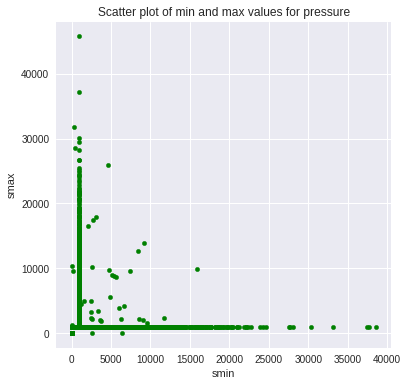

In [60]:
sg_data.plot.scatter(x='smin',y='smax',c='g',figsize=(6,6))
plt.title("Scatter plot of min and max values for pressure")
plt.show()

Original distributions for pressure data:


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


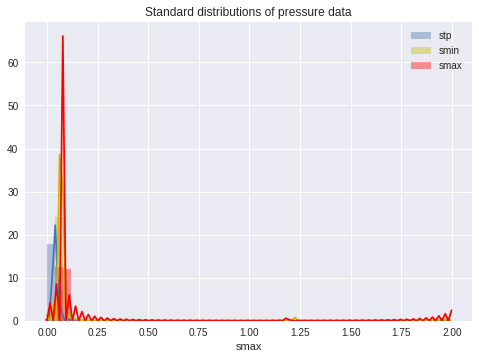

Distributions for pressure data after outlier replacement:


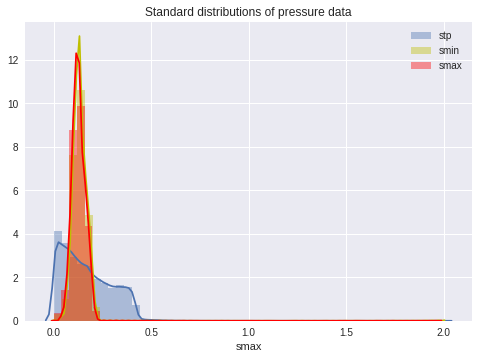

In [22]:
print("Original distributions for pressure data:")

sns.distplot(vit_data['stp'],label="stp")
sns.distplot(vit_data['smin'],color='y',label="smin")
sns.distplot(vit_data['smax'],color='r',label="smax")
plt.legend(loc='best')
plt.title("Standard distributions of pressure data")
plt.show()

# Calculate new values with outliers reset to mean
stp_series = set_outlier_to_mean(vit_data['stp'].copy())
smin_series = set_outlier_to_mean(vit_data['smin'])
smax_series = set_outlier_to_mean(vit_data['smax'])

# Update dataframe with modified values
vit_data['stp'] = stp_series.values
vit_data['smin'] = smin_series.values
vit_data['smax'] = smax_series.values

print("Distributions for pressure data after outlier replacement:")

sns.distplot(vit_data['stp'],label="stp")
sns.distplot(vit_data['smin'],color='y',label="smin")
sns.distplot(vit_data['smax'],color='r',label="smax")
plt.legend(loc='best')
plt.title("Standard distributions of pressure data")
plt.show()


['prcp' 'stp' 'smax' 'smin' 'gbrd' 'temp' 'dewp' 'tmax' 'dmax' 'tmin'
 'dmin' 'hmdy' 'hmax' 'hmin' 'wdsp' 'wdct' 'gust']


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


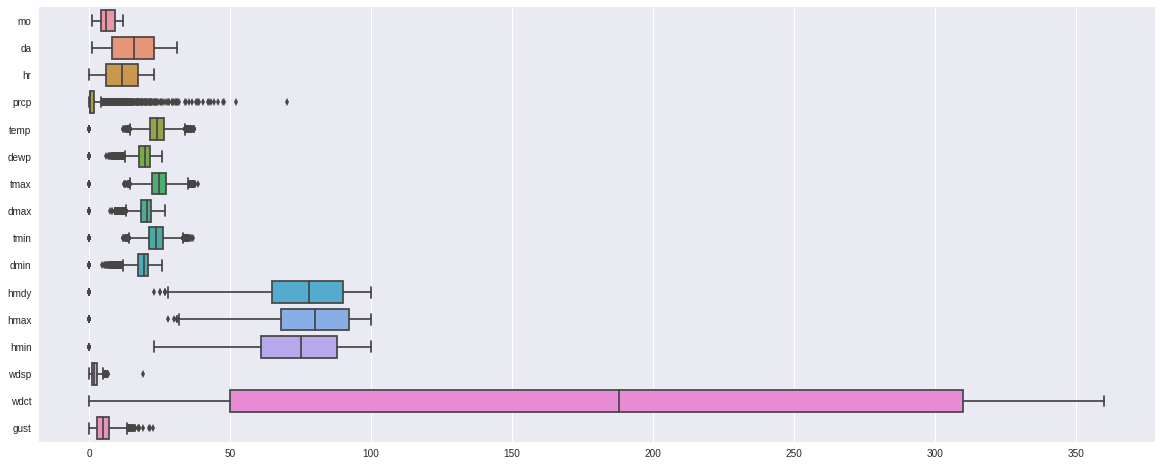

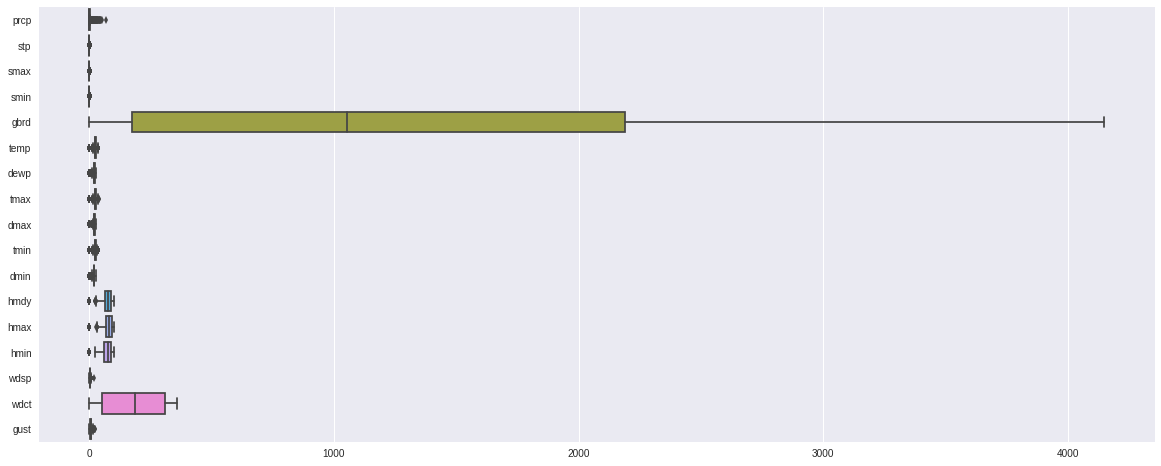

In [23]:
import seaborn as sns

vit_pressure = vit_data[['stp','smax','smin']].copy()
vit_no_pressure = vit_data.drop(columns=['mdct','stp','smax','smin','gbrd','yr'])
vit_temp = vit_data.drop(columns=['mdct','date','yr','mo','da','hr'])
print(vit_temp.columns.values)

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=vit_no_pressure,orient="h")
plt.show(ax)

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=vit_temp,orient="h")
plt.show(ax)


In [24]:
check_nulls(vit_data,"Vitoria data")
print("Vitoria data precipitation correlation:")
print(vit_data.corr().iloc[:,4])

vit_data = vit_data.fillna(0)

check_nulls(vit_data,"Vitoria data")
print("Vitoria data precipitation correlation:")
print(vit_data.corr().iloc[:,4])


Null values in Vitoria data:
(86952, 23)
prcp  -  78849
gbrd  -  36536
Vitoria data precipitation correlation:
yr     -0.051814
mo      0.010304
da      0.012654
hr      0.014514
prcp    1.000000
stp     0.036621
smax   -0.112944
smin   -0.121051
gbrd   -0.081553
temp    0.177027
dewp    0.204398
tmax    0.187236
dmax    0.206573
tmin    0.181808
dmin    0.206123
hmdy    0.210657
hmax    0.201850
hmin    0.201283
wdsp    0.197568
wdct    0.040858
gust    0.268033
Name: prcp, dtype: float64
Null values in Vitoria data:
(86952, 23)
Vitoria data precipitation correlation:
yr     -0.012813
mo      0.018908
da      0.009320
hr     -0.012580
prcp    1.000000
stp     0.013371
smax   -0.018012
smin   -0.018270
gbrd   -0.074663
temp   -0.054967
dewp    0.069102
tmax   -0.048367
dmax    0.065321
tmin   -0.048466
dmin    0.072018
hmdy    0.138798
hmax    0.129554
hmin    0.128925
wdsp   -0.030563
wdct    0.005184
gust    0.021926
Name: prcp, dtype: float64


MSE for  Simple linear regression model:
 1.6052053622353375


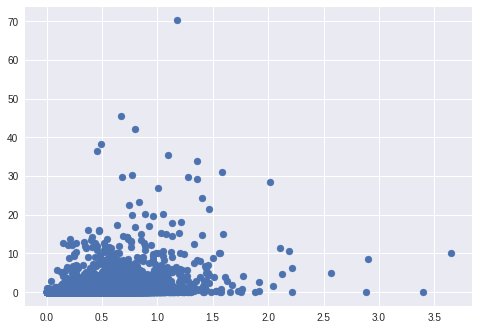

MSE for  Simple linear regression model:
 0.859507991506036


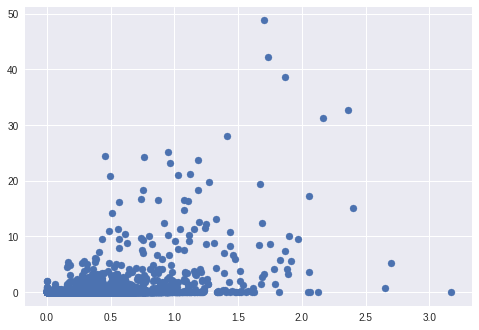

In [0]:
run_min_linear_regression(sg_data)


Running logistic regression on minimally processed Vitoria data:
Accuracy of Simple logistic regression  classifier on test set:
 0.9404278156865752
Simple logistic regression confusion matrix:
[[23689   249]
 [ 1305   843]]
Logistic Regression coefficients:



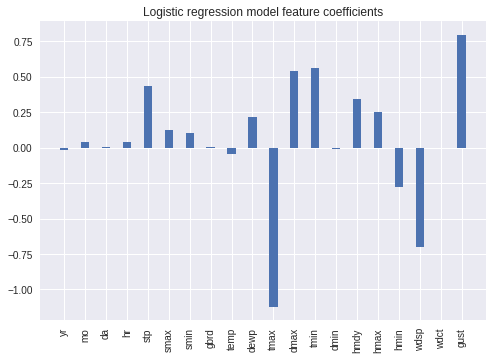

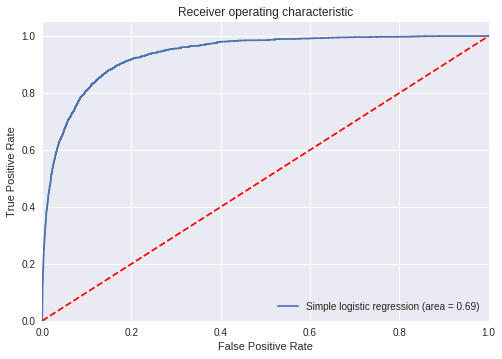

Running logistic regression on minimally processed Sao Goncalo data:
Accuracy of Simple logistic regression  classifier on test set:
 0.9788597053171044
Simple logistic regression confusion matrix:
[[22779    37]
 [  458   141]]
Logistic Regression coefficients:



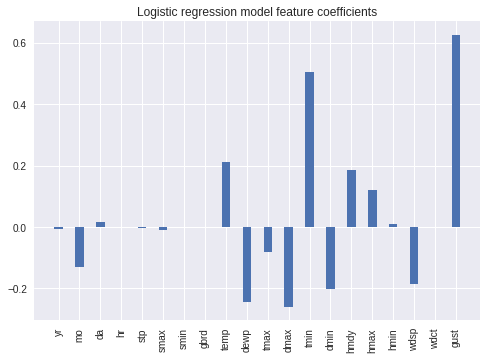

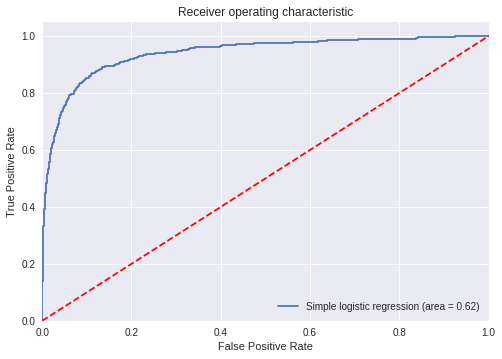

In [27]:
print("Running logistic regression on minimally processed Vitoria data:")
run_min_logistic_regression(vit_data)
print("Running logistic regression on minimally processed Sao Goncalo data:")
run_min_logistic_regression(sg_data)

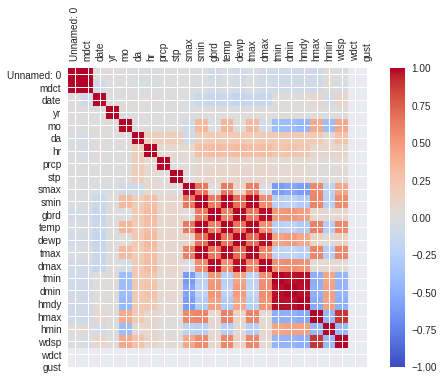

In [0]:
import matplotlib.pyplot as plt
corr = vit_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(vit_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(vit_data.columns)
ax.set_yticklabels(vit_data.columns)
plt.show()

In [10]:
test_df = weather_data.head(100)
print(test_df.shape)
test_df.head()

(100, 32)


,Unnamed: 0,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,...,29.7,16.8,25.5,10.8,35,58,32,3.2,101,6.5
1,1,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,...,29.9,13.6,29.0,12.2,39,39,35,3.6,94,6.4
2,2,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,...,29.0,14.0,27.4,13.6,44,44,39,2.5,93,6.9
3,3,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,...,27.4,16.9,25.8,14.1,58,58,44,1.7,96,5.8
4,4,178,SÃO GONÇALO,237,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,...,26.3,17.0,25.3,16.4,57,58,56,3.1,110,7.5


### Look at feature values

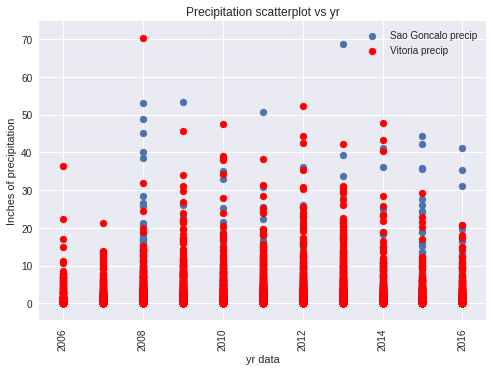

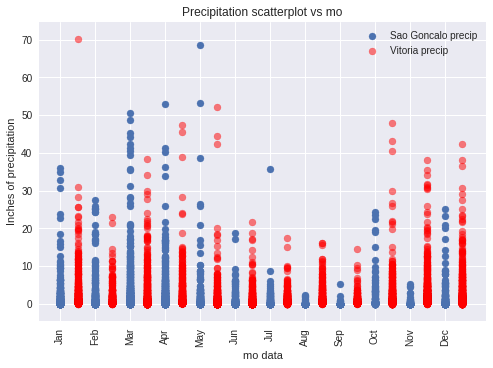

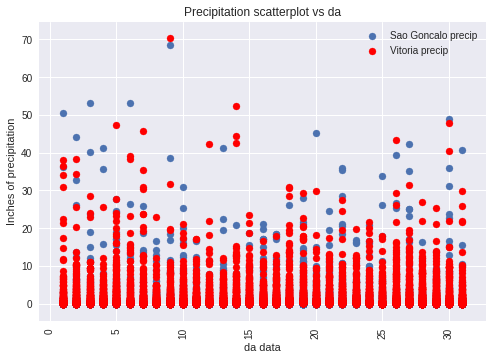

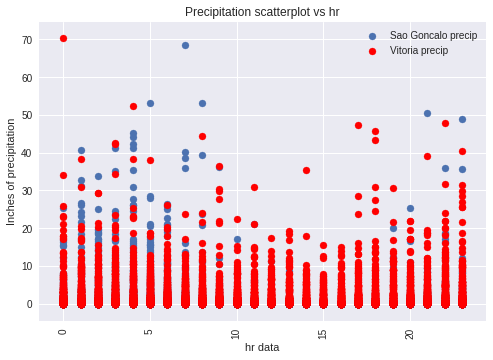

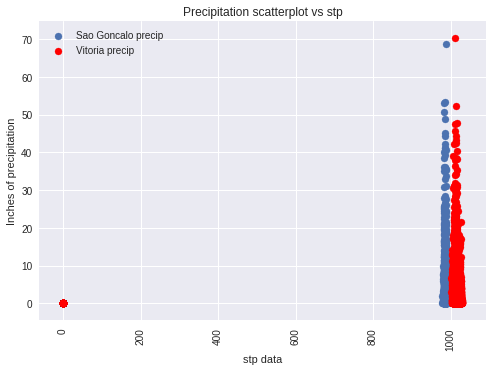

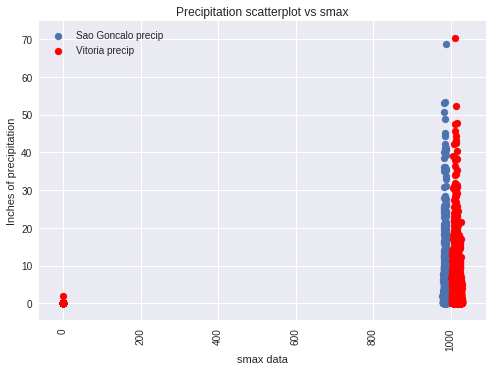

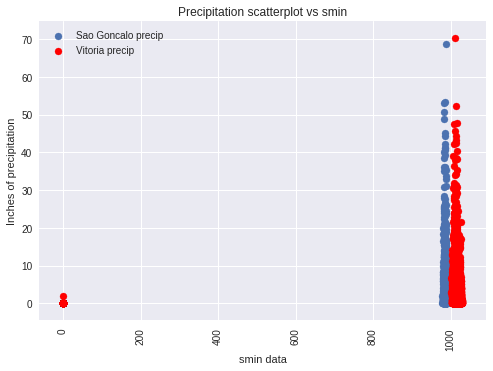

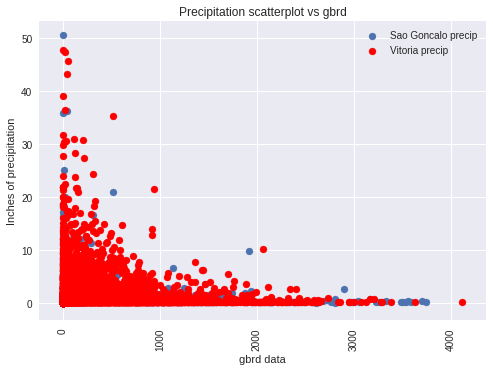

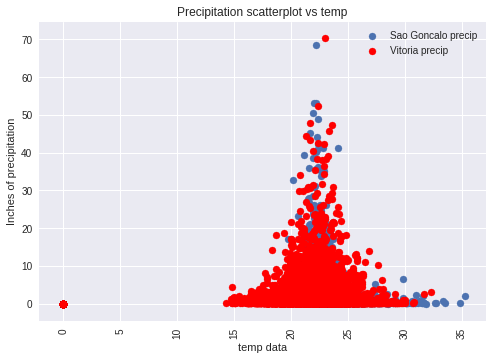

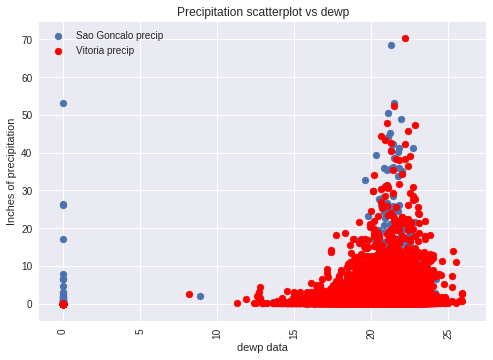

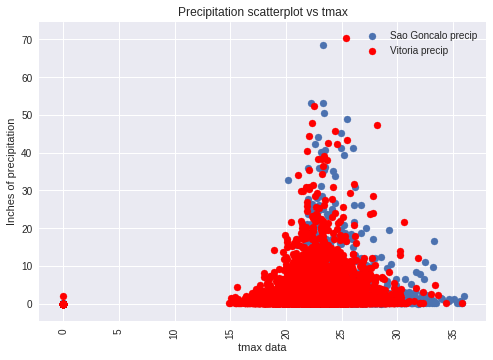

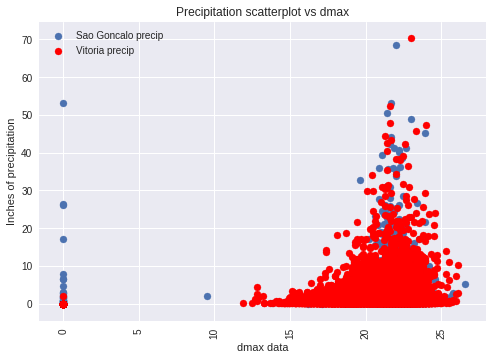

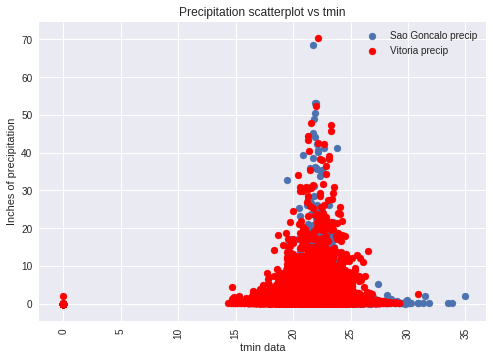

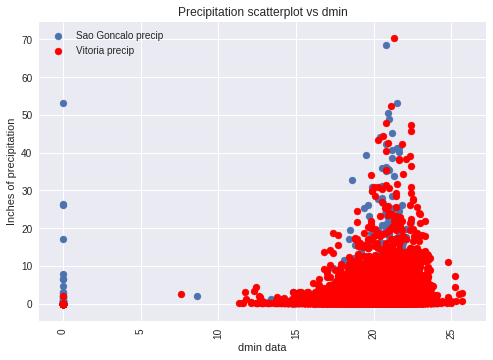

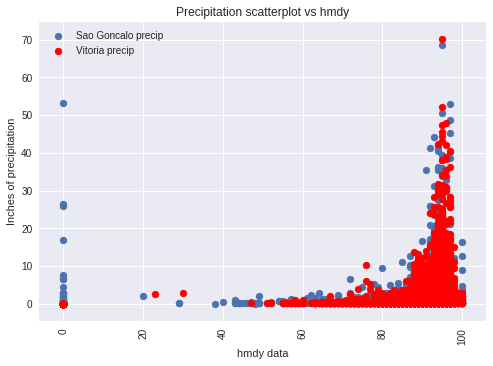

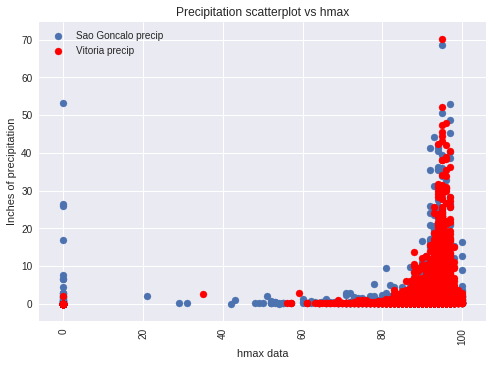

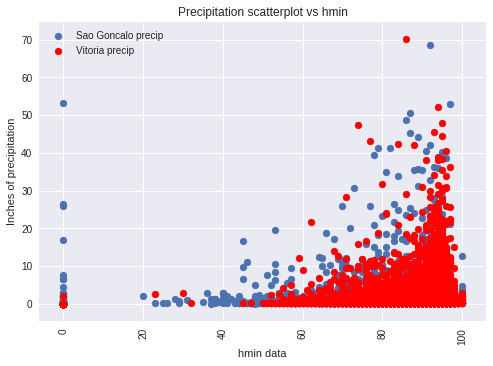

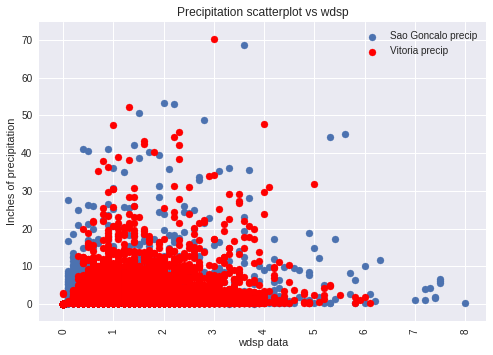

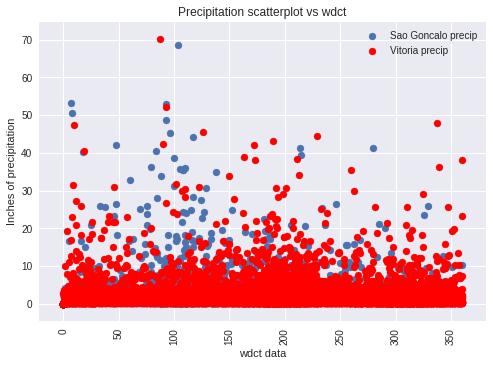

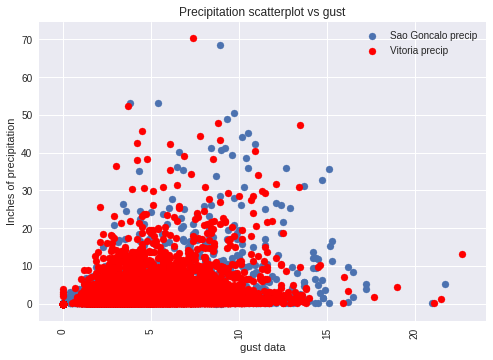

In [0]:
cols = np.array(weather_data.columns)
skip_cols = ['prcp','Unnamed: 0','wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date']
for col in weather_data.columns.values:
  if col not in skip_cols:
    precip_scatter(col)

### Run assertions

In [18]:
# Ensure that no invalid dew points are in data set
weather_data['valid_dew'] = weather_data['dewp'] > weather_data['temp']
assert(weather_data['valid_dew'].unique() == False)
weather_data = weather_data.drop(columns='valid_dew')

# Ensure that no invalid pressure points are in the data set
weather_data['valid_stp'] = weather_data['smin'] > weather_data['smax']
print(weather_data['valid_stp'].describe())
#assert(weather_data['valid_stp'].unique() == False)
weather_data = weather_data.drop(columns='valid_stp')


count     165000
unique         2
top        False
freq      162640
Name: valid_stp, dtype: object


In [25]:
from datetime import datetime
from datetime import timedelta
  
vit_data['mdct'] = pd.to_datetime(vit_data['mdct'])
print(vit_data.iloc[5])
print("Found data")
print(vit_data.loc[vit_data['mdct'] == vit_data.iloc[5]['mdct'] - timedelta(hours=1.5)])



2007-11-06 00:00:00
mdct    2006-10-31 05:00:00
date             2006-10-31
yr                     2006
mo                       10
da                       31
hr                        5
prcp                      0
stp                0.035608
smax                1.18699
smin                1.22056
gbrd                      0
temp                      0
dewp                      0
tmax                      0
dmax                      0
tmin                      0
dmin                      0
hmdy                      0
hmax                      0
hmin                      0
wdsp                      0
wdct                      0
gust                      0
Name: 78053, dtype: object
Found data
Empty DataFrame
Columns: [mdct, date, yr, mo, da, hr, prcp, stp, smax, smin, gbrd, temp, dewp, tmax, dmax, tmin, dmin, hmdy, hmax, hmin, wdsp, wdct, gust]
Index: []

[0 rows x 23 columns]
